In [1]:
import anndata
import h5py
import json
import numpy as np
import pandas as pd
import pathlib
import scanpy as sc

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### Load the data

In [2]:
def load_adata(Qced_adata_path):
    
    adata = anndata.read_h5ad(Qced_adata_path)

    # filter the initial QCed cells
    QC_flag = [adata.obs[x] for x in adata.obs.columns if 'flag' in x]
    if len(QC_flag) > 0:
        QC_flag = np.column_stack(QC_flag).all(axis=-1)
        adata = adata[QC_flag]

    if 'Ensemble_ID' in adata.var:
        # reset the var name to Ensemble ID 
        adata.var.set_index('Ensemble_ID', inplace=True)
    if 'real_gene_name' in adata.var:
        adata.var = adata.var.rename(columns={'real_gene_name':'Gene'})

    return adata


In [ ]:
# Qced file path 
chip11_file_path = r'./../../HumanBG_stereo_seq_data/chip11_Y00550A6C8/re_aligned/Y00550A6C8/outs/feature_expression/Y00550A6C8.adjusted.cellbin_QC_flaged_05292025.h5ad'


In [ ]:
%%time
chip11_adata = load_adata(chip11_file_path)

/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/site-packages/pandas/core/frame.py:6191: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  frame.index = index


CPU times: user 3.32 s, sys: 834 ms, total: 4.15 s
Wall time: 4.4 s


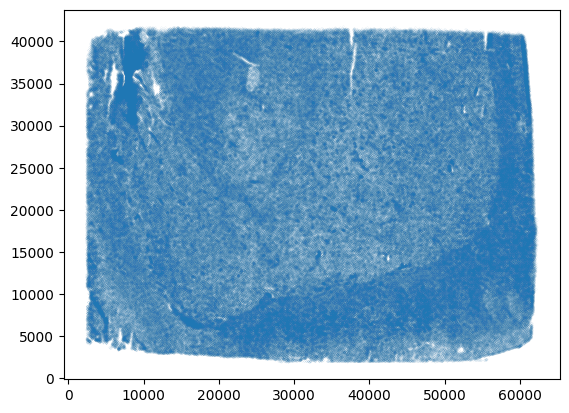

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(chip11_adata.obsm['spatial'][:,0],chip11_adata.obsm['spatial'][:,1], s = 0.001)
plt.show()



In [6]:
# make the cell ID unique 
chip11_adata.obs_names =  chip11_adata.obs_names.map(lambda x: 'chip11_' + str(x))


In [7]:
#### concatenate them and delete to free up space
adata = chip11_adata.copy()

In [8]:
adata = adata.copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 910350 × 64832
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag'
    var: 'Gene', 'Accession', 'gene_biotype'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'

In [10]:
# keep record of the raw count 
adata.layers['raw_count'] = adata.X.copy()

### Level 1: Graymatter(Striatum), whitematter and ependymal zone

#### Count Normalization

In [11]:
total_count = np.array(adata.X.sum(axis=-1))
sc.pp.normalize_total(adata, target_sum=np.median(total_count))
sc.pp.log1p(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 910350 × 64832
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag'
    var: 'Gene', 'Accession', 'gene_biotype'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn', 'log1p'
    obsm: 'cell_border', 'spatial'
    layers: 'raw_count'

#### Compute the spatially weighted gaussian average of the expression matrix

In [94]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm

genes = list(adata.var.index)
X = adata.obsm['spatial']
d=500
D = radius_neighbors_graph(
        X, radius=d,          # keep neighbours within d
        mode='distance',      # store the actual distances (use 'connectivity' for 1s)
        include_self=True,   # no self–loops
        metric='euclidean',   # or 'cosine', etc.
        n_jobs=-1             # parallel over all CPU cores
    ).tocsr() 
W = D.copy()
w=200
W.data = np.exp(-0.5*(W.data/w)**2)

row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
#row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
D_inv = sp.diags(1.0 / row_sum)
W_norm = D_inv @ W
expr_mat = adata.X  # (n_cells × n_genes)
expr_neigh = W_norm[::11].dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                            # downsample by 11. This is for testing, later maybe better to use full data
adataN = sc.AnnData(expr_neigh, var=adata.var)
adataN.obsm['X_spatial']=adata.obsm['spatial'][::11]
adataN.obs_names = adata.obs_names[::11] # add the cell ID names
# keep record of the raw count 
adataN.layers['raw_count'] = adata.layers['raw_count'][::11]




In [95]:
# add the chip information, 
adataN.obs['Chip'] = adataN.obs_names.map(lambda x: x.split('_')[0])
adataN.obs['Chip'] = adataN.obs['Chip'].astype('category')

In [96]:
adataN

AnnData object with n_obs × n_vars = 82760 × 64832
    obs: 'Chip'
    var: 'Gene', 'Accession', 'gene_biotype'
    obsm: 'X_spatial'
    layers: 'raw_count'

#### Compute highly variable genes

In [97]:
%%time
# HVG
sc.pp.highly_variable_genes(
    adataN,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=5000,    # common default
    subset=True,         # keep only HVGs moving forward
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


CPU times: user 36.4 s, sys: 2.53 s, total: 38.9 s
Wall time: 9.3 s


In [98]:
adataN

AnnData object with n_obs × n_vars = 82760 × 5000
    obs: 'Chip'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_spatial'
    layers: 'raw_count'

### Perform the clustering

In [99]:
%%time
sc.pp.scale(adataN, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adataN, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 26min 28s, sys: 3.65 s, total: 26min 32s
Wall time: 23.4 s


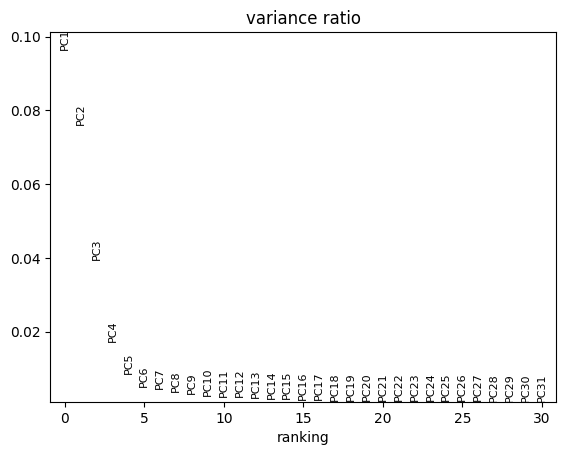

In [100]:
sc.pl.pca_variance_ratio(adataN)

- Note: their is large weight to PC1. And as shown below, this PC1 is coming from the contaminating neuronal genes. 

In [101]:
adataN.var[adataN.var['Gene']=='PENK']

,Gene,Accession,gene_biotype,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
Ensemble_ID,,,,,,,,,,
ENSG00000181195,PENK,ENSG00000181195,protein_coding,True,6.0,0.055372,2.785170e-03,4.565214,0.055372,0.052775
ENSG00000287479,PENK,ENSG00000287479,NaN,True,3460.0,0.000001,5.274904e-09,1.421631,0.000001,0.000073


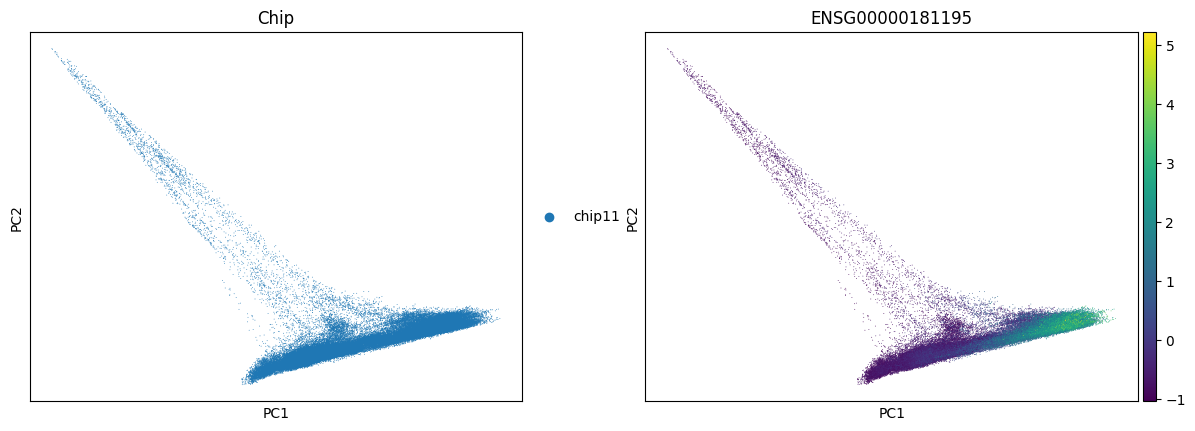

In [102]:
sc.pl.pca(adataN,color=['Chip','ENSG00000181195'], dimensions=[(0,1)])

In [110]:
%time
sc.pp.neighbors(adataN, n_neighbors=15, n_pcs = 40, use_rep = 'X_pca')  # uses PCA space by default
sc.tl.umap(adataN, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adataN, resolution=0.2)  

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 8.11 μs


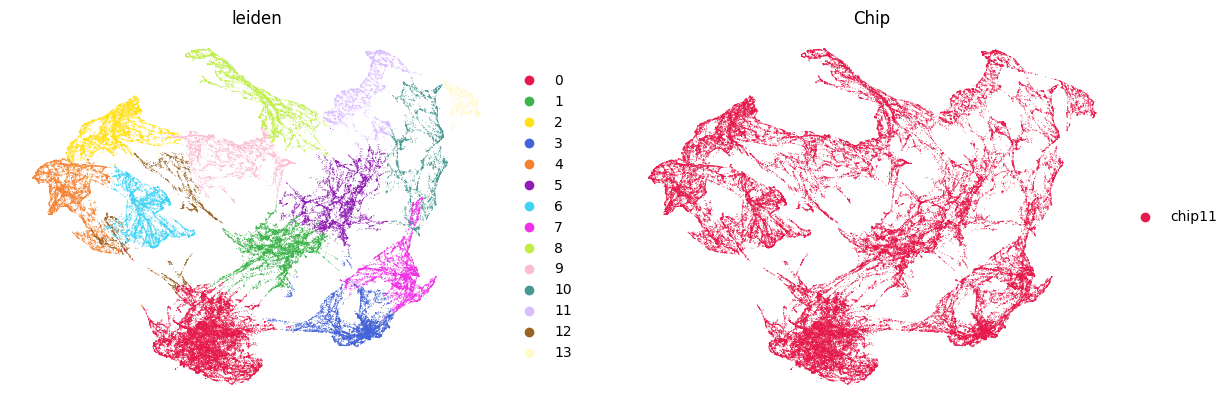

In [111]:
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
sc.pl.umap(adataN,
           color=["leiden","Chip"],        # what to colour by
           frameon=False,         # remove axes frame
        #    legend_loc="on data",
           palette=cmap)  # put cluster labels on the points


In [112]:
leiden = adataN.obs['leiden']
np.unique(leiden)

array(['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7',
       '8', '9'], dtype=object)

In [113]:
color_map = {ld:clr for ld,clr in zip(adataN.obs['leiden'].cat.categories, adataN.uns['leiden_colors'])}
color_map

{'0': '#e6194b',
 '1': '#3cb44b',
 '2': '#ffe119',
 '3': '#4363d8',
 '4': '#f58231',
 '5': '#911eb4',
 '6': '#42d4f4',
 '7': '#f032e6',
 '8': '#bfef45',
 '9': '#fabed4',
 '10': '#469990',
 '11': '#dcbeff',
 '12': '#9a6324',
 '13': '#fffac8'}

In [114]:
adataN

AnnData object with n_obs × n_vars = 82760 × 5000
    obs: 'Chip', 'leiden'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'Chip_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [115]:
np.sort(np.unique(adataN.obs['leiden']).astype(int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

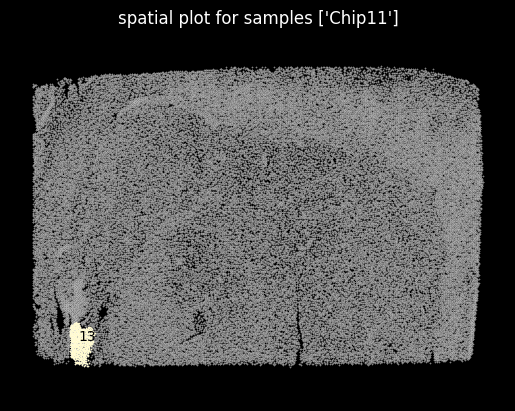

In [130]:
import matplotlib.pylab as plt
import seaborn as sns

chip = ['Chip11']
XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['leiden']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in ['13']:#np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for samples {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

#### Annotation

In [131]:
# annotation 
ledien_annotation = {0:'Gray_matter',
                     1:'Gray_matter',
                     2:'White_matter',
                     3:'Gray_matter',
                     4:'White_matter',
                     5:'Gray_matter',
                     6:'White_matter',
                     7:'White_matter',
                     8:'White_matter',
                     9:'White_matter',
                     10:'ependymal_zone',
                     11:'White_matter',
                     12:'White_matter',
                     13:'ependymal_zone'
                     
                }
ledien_annotation = {str(k):v for k,v in ledien_annotation.items()}


In [133]:
adataN.obs['Highlevel_spatialmodule'] = adataN.obs['leiden'].replace(ledien_annotation) 
adataN.obs['Highlevel_spatialmodule'] 

/tmp/ipykernel_2280709/2841511842.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adataN.obs['Highlevel_spatialmodule'] = adataN.obs['leiden'].replace(ledien_annotation)


chip11_120748710561774    White_matter
chip11_123141007345614    White_matter
chip11_124867584198618    White_matter
chip11_125524714194900    White_matter
chip11_130777459197944    White_matter
                              ...     
chip11_185010011284125     Gray_matter
chip11_197203423437328     Gray_matter
chip11_201588585046635     Gray_matter
chip11_218566590767636     Gray_matter
chip11_156963874841398     Gray_matter
Name: Highlevel_spatialmodule, Length: 82760, dtype: category
Categories (3, object): ['Gray_matter', 'White_matter', 'ependymal_zone']

In [134]:
# remove the artifact clusteres 
keep =  adataN.obs['Highlevel_spatialmodule'].isin(['artifact'])
adataN = adataN[~keep].copy()
adataN

AnnData object with n_obs × n_vars = 82760 × 5000
    obs: 'Chip', 'leiden', 'Highlevel_spatialmodule'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'Chip_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

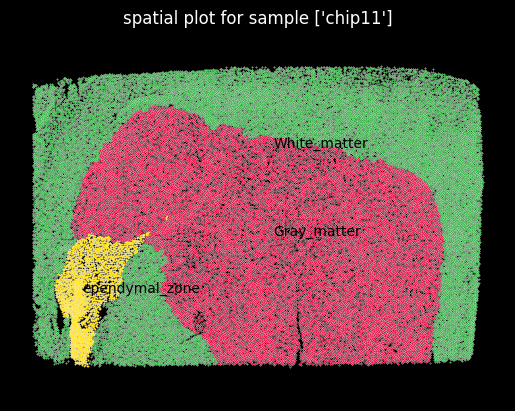

In [135]:
import matplotlib.pylab as plt
import seaborn as sns
chip = ['chip11']
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adataN.obs['Highlevel_spatialmodule'].cat.categories)}
XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['Highlevel_spatialmodule']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [136]:
adata

AnnData object with n_obs × n_vars = 910350 × 64832
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag'
    var: 'Gene', 'Accession', 'gene_biotype'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn', 'log1p'
    obsm: 'cell_border', 'spatial'
    layers: 'raw_count'

#### Transefer the label to the full dataset

In [138]:
# adata
import scipy
import scipy.spatial
from tqdm import tqdm 
adata.obs['Highlevel_spatialmodule'] = 'unassigned'
    
ref_cellID = adataN.obs_names
query_cellID = adata.obs_names

ref_spatial = adataN[ref_cellID].obsm['X_spatial'].copy()
query_spatial = adata[query_cellID].obsm['spatial']
tree = scipy.spatial.KDTree(ref_spatial)
_,ind = tree.query(query_spatial,k=1)
labels = adataN.obs.loc[ref_cellID,'Highlevel_spatialmodule'].values
adata.obs.loc[query_cellID,'Highlevel_spatialmodule'] = labels[ind]

adata.obs['Highlevel_spatialmodule'] = adata.obs['Highlevel_spatialmodule'].astype('category')

- visualize the full data to make sure the label transfer is done correctly 

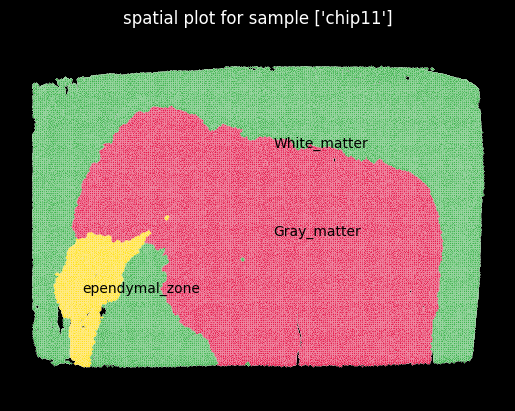

In [140]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['Highlevel_spatialmodule'].cat.categories)}
chip_ID = ['chip11']
XN = np.array(adata.obsm['spatial'])
leiden = adata.obs['Highlevel_spatialmodule']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

### Level-2: Subclustering of the Gray-matter -> Ca(Cuadate),Pu(Putamen) and NAC(nucleus accumbens)

In [142]:
np.unique(adataN.obs['leiden'])

array(['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7',
       '8', '9'], dtype=object)

In [144]:
color_map = {ld:clr for ld,clr in zip(adataN.obs['leiden'].cat.categories, adataN.uns['leiden_colors'])}
color_map

{'0': np.str_('#e6194b'),
 '1': np.str_('#3cb44b'),
 '2': np.str_('#ffe119'),
 '3': np.str_('#4363d8'),
 '4': np.str_('#f58231'),
 '5': np.str_('#911eb4'),
 '6': np.str_('#42d4f4'),
 '7': np.str_('#f032e6'),
 '8': np.str_('#bfef45'),
 '9': np.str_('#fabed4'),
 '10': np.str_('#469990'),
 '11': np.str_('#dcbeff'),
 '12': np.str_('#9a6324'),
 '13': np.str_('#fffac8')}

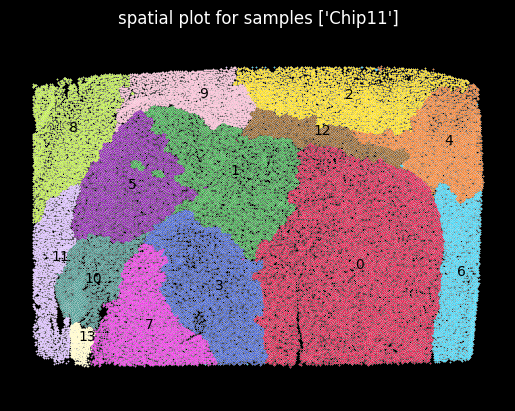

In [161]:
import matplotlib.pylab as plt
import seaborn as sns

chip = ['Chip11']
XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['leiden']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for samples {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

### Annotation

In [162]:
# annotation 
ledien_annotation = {0:'Putamen',
                     1:'NAC',
                     2:'white_matter',
                     3:'Gpe',
                     4:'white_matter',
                     5:'NAC',
                     6:'white_matter',
                     7:'white_matter',
                     8:'white_matter',
                     9:'white_matter',
                     10:'ependymal_zone',
                     11:'white_matter',
                     12:'white_matter',
                     13:'ependymal_zone',
                }
ledien_annotation = {str(k):v for k,v in ledien_annotation.items()}

In [163]:
adataN.obs['spatialmodule_GrayMatter_subclustered'] = adataN.obs['leiden'].replace(ledien_annotation) 
adataN.obs['spatialmodule_GrayMatter_subclustered'] 

/tmp/ipykernel_2280709/2503738448.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adataN.obs['spatialmodule_GrayMatter_subclustered'] = adataN.obs['leiden'].replace(ledien_annotation)


chip11_120748710561774    white_matter
chip11_123141007345614    white_matter
chip11_124867584198618    white_matter
chip11_125524714194900    white_matter
chip11_130777459197944    white_matter
                              ...     
chip11_185010011284125         Putamen
chip11_197203423437328         Putamen
chip11_201588585046635         Putamen
chip11_218566590767636         Putamen
chip11_156963874841398         Putamen
Name: spatialmodule_GrayMatter_subclustered, Length: 82760, dtype: category
Categories (5, object): ['Putamen', 'NAC', 'white_matter', 'Gpe', 'ependymal_zone']

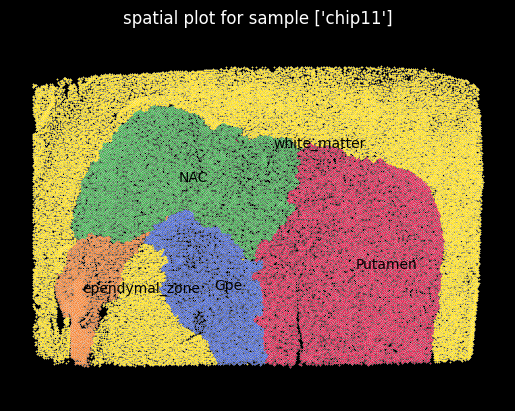

In [164]:
import matplotlib.pylab as plt
import seaborn as sns
chip = ['chip11']
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adataN.obs['spatialmodule_GrayMatter_subclustered'].cat.categories)}
XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['spatialmodule_GrayMatter_subclustered']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

#### Transfer the label to the whole dataset 

In [165]:
# adata
import scipy
import scipy.spatial
from tqdm import tqdm 
adata.obs['spatialmodule_GrayMatter_subclustered'] = 'unassigned'
    
ref_cellID = adataN.obs_names
query_cellID = adata.obs_names

ref_spatial = adataN[ref_cellID].obsm['X_spatial'].copy()
query_spatial = adata[query_cellID].obsm['spatial']
tree = scipy.spatial.KDTree(ref_spatial)
_,ind = tree.query(query_spatial,k=1)
labels = adataN.obs.loc[ref_cellID,'spatialmodule_GrayMatter_subclustered'].values
adata.obs.loc[query_cellID,'spatialmodule_GrayMatter_subclustered'] = labels[ind]

adata.obs['spatialmodule_GrayMatter_subclustered'] = adata.obs['spatialmodule_GrayMatter_subclustered'].astype('category')

- visualize the whole data to see if the data tranfer is done correctly 

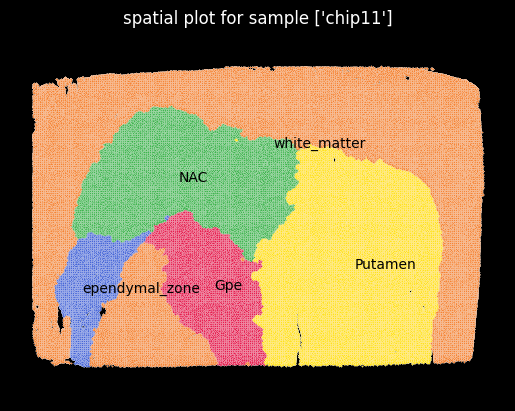

In [166]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['spatialmodule_GrayMatter_subclustered'].cat.categories)}
chip_ID = ['chip11']
XN = np.array(adata.obsm['spatial'])
leiden = adata.obs['spatialmodule_GrayMatter_subclustered']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

- save the annotations

In [ ]:
# save what you have for known.
adata.obs.to_csv(r'./../../Spatial_transcriptional_module_analysis/processed_data/chip11/Hierarchical_spatialModule_chip11.csv')